In [48]:
import matplotlib.pyplot as plt # 이미지 시각화 라이브러리
import torch
import torch.nn.functional as F # for one-hot encoding
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

print(torch.__version__)
print(np.__version__)

2.7.1+cu118
2.2.6


In [49]:
# GPU 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [50]:
dataset_dir = "~/work/data_augmentation/data/Images/" # 데이터셋 경로

In [51]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 통일
    transforms.ToTensor(),  # Tensor 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
])
full_dataset = ImageFolder(root=dataset_dir, transform=transform)

total_size = len(full_dataset)
train_size = int(0.583 * total_size)  # 약 12,000개
test_size = total_size - train_size   # 약 8,580개
ds_train, ds_test = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=32, shuffle=False)
ds_info = {
    "num_classes": len(full_dataset.classes),
    "class_names": full_dataset.classes
}

In [52]:
def normalize_and_resize_img():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 통일
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
    ])

In [53]:
# 데이터셋을 가공하는 메인함수
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False):  # with_aug: augmentation 적용 여부
    # 데이터셋에 transform 적용 (augmentation 포함)
    transform = normalize_and_resize_img()  # 기본 transform

    if not is_test and with_aug:    # 테스트셋이 아니고 augmentation 적용 시
        dataset.dataset.transform = transforms.Compose([    # transform들을 묶음
            *augment().transforms,  # augmentation transform들  # 리스트 언패킹 사용    
            *transform.transforms   # 기본 transform들  # 리스트 언패킹 사용
        ])
    else:
        dataset.dataset.transform = transform   # 기본 transform만 적용

    return DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)  # DataLoader 반환


ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)  # augmentation 미적용

In [54]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다.
data_iter = iter(ds_train_no_aug)
images, labels = next(data_iter)

# 첫 번째 배치에서 두 개의 이미지 선택
image_a = images[0].permute(1, 2, 0).numpy()
image_b = images[1].permute(1, 2, 0).numpy()
label_a = labels[0].item()
label_b = labels[1].item()

# 정규화된 텐서를 다시 [0, 1] 범위로 조정
image_a = (image_a * 0.5) + 0.5
image_b = (image_b * 0.5) + 0.5

In [55]:
def get_clip_box(image_a, image_b):
    # image.shape = (channel, height, width)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # Get center of box
    x = torch.randint(0, image_size_x, (1,)).item()
    y = torch.randint(0, image_size_y, (1,)).item()

    width = max(1, int(image_size_x * torch.sqrt(1 - torch.rand(1)).item()))
    height = max(1, int(image_size_y * torch.sqrt(1 - torch.rand(1)).item()))

    # Clip box in image and get minmax bbox
    x_min = max(0, x - width // 2)
    y_min = max(0, y - height // 2)
    x_max = min(image_size_x, x + width // 2 + 1)
    y_max = min(image_size_y, y + height // 2 + 1)

    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x :', x_min, x_max)
print('y :', y_min, y_max)

x : 1 2
y : 44 93


In [56]:
import torch.nn.functional as F

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    # 바운딩 박스 비율 계산
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = mixed_area / total_area

     # 원-핫 벡터 변환
    if isinstance(label_a, int):
        label_a = F.one_hot(torch.tensor(label_a), num_classes=num_classes).float()
    if isinstance(label_b, int):
        label_b = F.one_hot(torch.tensor(label_b), num_classes=num_classes).float()

    # 비율에 따라 라벨 혼합
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

# 예제 실행
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
print(mixed_label)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0729, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9271,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

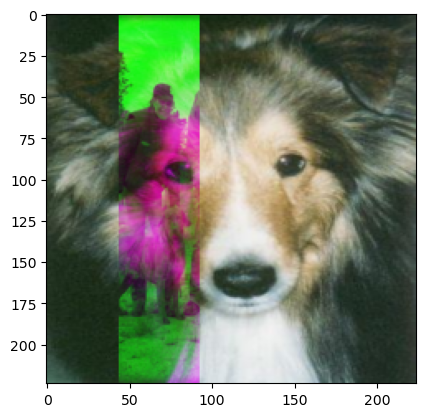

In [57]:
import torch

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (C, H, W)
    image_size_x = image_a.shape[2]  # Width
    image_size_y = image_a.shape[1]  # Height

    if isinstance(image_a, np.ndarray):
        image_a = torch.from_numpy(image_a).to(device)
    if isinstance(image_b, np.ndarray):
        image_b = torch.from_numpy(image_b).to(device)

    top = image_a[:, :y_min, :]
    middle_left = image_a[:, y_min:y_max, :x_min]
    middle_center = image_b[:, y_min:y_max, x_min:x_max]
    middle_right = image_a[:, y_min:y_max, x_max:]
    bottom = image_a[:, y_max:, :]

    top = top.to(device)
    middle_left = middle_left.to(device)
    middle_center = middle_center.to(device)
    middle_right = middle_right.to(device)
    bottom = bottom.to(device)

    # 중간 부분(왼쪽, 중앙, 오른쪽) 결합
    middle = torch.cat([middle_left, middle_center, middle_right], dim=2)

    # 전체 이미지 결합 (위 + 중간 + 아래)
    mixed_img = torch.cat([top, middle, bottom], dim=1)

    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)

plt.imshow(mixed_img.cpu().numpy())
plt.show()

In [58]:
# 확인 사항: mixed_image가 [3, 224, 224] 형태인지 확인.
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
print("Mixed image shape:", mixed_img.shape)

Mixed image shape: torch.Size([224, 224, 3])


In [13]:
"""
이 코드에 문제가 있어서 아래 코드로 대체
def cutmix(images, labels, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]

        j = torch.randint(0, batch_size, (1,)).item()  # 다른 샘플 선택
        image_b = images[j]
        label_b = labels[j]

        # 바운딩 박스 생성
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        # 이미지 섞기
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

    # 텐서 변환
    mixed_imgs = torch.stack(mixed_imgs).reshape(batch_size, 3, img_size, img_size)
    mixed_labels = torch.stack(mixed_labels).reshape(batch_size, num_classes)

    return mixed_imgs, mixed_labels

print("=3")
"""

=3


In [59]:
def cutmix(images, labels, prob=1.0, num_classes=120):
    if torch.rand(1) > prob:
        return images, torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    
    batch_size = images.size(0)
    index = torch.randperm(batch_size).to(images.device)
    mixed_imgs = images.clone()  # [batch_size, 3, 224, 224]
    
    # 바운딩 박스 및 비율 계산
    img_size = images.size(2)
    lam = np.random.beta(1.0, 1.0)
    lam = max(lam, 1 - lam)
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(img_size * cut_rat)
    cut_h = int(img_size * cut_rat)
    cx = np.random.randint(img_size)
    cy = np.random.randint(img_size)
    x_min = np.clip(cx - cut_w // 2, 0, img_size)
    y_min = np.clip(cy - cut_h // 2, 0, img_size)
    x_max = np.clip(cx + cut_w // 2, 0, img_size)
    y_max = np.clip(cy + cut_h // 2, 0, img_size)
    
    # 이미지 섞기
    mixed_imgs[:, :, y_min:y_max, x_min:x_max] = images[index, :, y_min:y_max, x_min:x_max]
    
    # 레이블 섞기
    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    labels_b = labels_one_hot[index]
    mixed_labels = lam * labels_one_hot + (1 - lam) * labels_b
    
    return mixed_imgs, mixed_labels

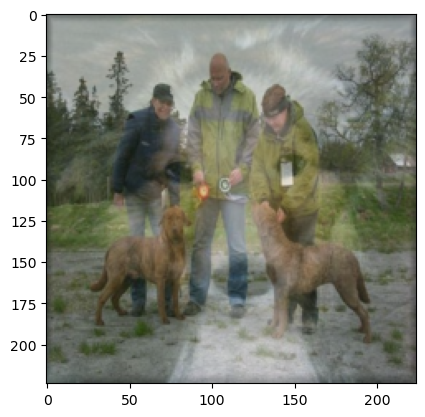

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.5924, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4076,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [60]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = torch.rand(1).item()  # 0~1 사이의 랜덤 값

    # 라벨 원핫 인코딩
    if isinstance(label_a, int):
        label_a = F.one_hot(torch.tensor(label_a), num_classes=num_classes).float()
    if isinstance(label_b, int):
        label_b = F.one_hot(torch.tensor(label_b), num_classes=num_classes).float()

    # 이미지와 라벨 혼합
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

# 예제 실행
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

plt.imshow(mixed_img)
plt.show()

print(mixed_label)

In [61]:
def mixup(images, labels, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]

        # 랜덤하게 다른 이미지 선택
        j = torch.randint(0, batch_size, (1,)).item()
        image_b = images[j]
        label_b = labels[j]

        # Mixup 적용
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # 배치 차원 추가
    mixed_imgs = torch.stack(mixed_imgs).view(batch_size, 3, img_size, img_size)  # (B, C, H, W)
    mixed_labels = torch.stack(mixed_labels).view(batch_size, num_classes)  # (B, num_classes)

    return mixed_imgs, mixed_labels

print('=3')

=3


In [62]:

# 이미지 정규화 및 크기 조정
def normalize_and_resize_img(image, label):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 조정
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
    ])
    return transform(image), label

# 데이터 증강 (좌우 반전, 밝기 조정)
def augment(image, label):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
        transforms.Lambda(lambda img: torch.clamp(img, 0, 1))  # 값 클리핑
    ])
    return transform(image), label

# 원-핫 인코딩
def onehot(label, num_classes=120):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# 데이터셋 적용
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    dataset = [(normalize_and_resize_img(img, lbl)) for img, lbl in dataset]

    if not is_test and with_aug:
        dataset = [(augment(img, lbl)) for img, lbl in dataset]

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)

    if not is_test and with_cutmix:
        dataloader = [(cutmix(img, lbl)) for img, lbl in dataloader]
    else:
        dataloader = [(img, onehot(lbl)) for img, lbl in dataloader]

    return dataloader

print('=3')

=3


In [63]:
import torch.nn as nn
import torchvision.models as models

# CutMix 모델 정의
num_classes = 120  # ds_info["class_names"] 대신 고정값 사용 (필요 시 수정)

# ResNet50 모델 초기화
CM_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
CM_resnet50.fc = nn.Linear(CM_resnet50.fc.in_features, num_classes)

# 추가 레이어 없이 기본 ResNet50 사용
# ResNet50 내부에 이미 AdaptiveAvgPool2d가 포함되어 있으므로 nn.Sequential 불필요

In [32]:
%%time
import torch.optim as optim

#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CM_resnet50.parameters(), lr=0.001)
def categorical_crossentropy(outputs, targets):
    log_probs = nn.functional.log_softmax(outputs, dim=1)
    loss = -torch.sum(targets * log_probs, dim=1).mean()
    return loss

    
def train(CM_resnet50, train_loader, test_loader, epochs, num_classes=120):
    CM_resnet50.to(device)
    optimizer = optim.SGD(CM_resnet50.parameters(), lr=0.001)
    history = {'val_accuracy': []}

    for epoch in range(epochs):
        CM_resnet50.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            # 레이블을 텐서로 변환
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.long)
            labels = labels.to(device)
            
            # CutMix 적용
            images, labels = cutmix(images, labels, prob=1.0, num_classes=num_classes)
            
            # 이미지 차원 디버깅
            if images.dim() != 4 or images.shape[1] != 3:
                print("Invalid train image shape:", images.shape)
                images = images.permute(0, 3, 1, 2) if images.shape[-1] == 3 else images
            
            optimizer.zero_grad()
            outputs = CM_resnet50(images)
            loss = categorical_crossentropy(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            _, true_labels = labels.max(1)
            total += true_labels.size(0)
            correct += predicted.eq(true_labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {train_acc:.2f}%")

        CM_resnet50.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device)
                # 레이블을 텐서로 변환 <-- 학습 루프에서 레이블을 강제로 텐서로 변환, 디버깅 출력 추가.
                if not isinstance(labels, torch.Tensor):
                    labels = torch.tensor(labels, dtype=torch.long)
                labels = labels.to(device)
                if images.dim() != 4 or images.shape[1] != 3:
                    print("Invalid test image shape:", images.shape)
                    images = images.permute(0, 3, 1, 2) if images.shape[-1] == 3 else images
                labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
                
                outputs = CM_resnet50(images)
                _, predicted = outputs.max(1)
                _, true_labels = labels.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= total
        val_acc = 100. * correct / total
        test_loss /= total
        test_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Test Loss={test_loss:.4f}, Acc={test_acc:.4f}")

    return history

CPU times: user 790 μs, sys: 5 μs, total: 795 μs
Wall time: 804 μs


In [35]:
EPOCH = 1
num_classes = 120  # Stanford Dogs 데이터셋
history_resnet50_CM = train(CM_resnet50, train_loader, test_loader, EPOCH, num_classes)

Epoch [1/1], Accuracy: 47.40%


ValueError: too many values to unpack (expected 2)

In [64]:

def categorical_crossentropy(outputs, targets):
    log_probs = nn.functional.log_softmax(outputs, dim=1)
    loss = -torch.sum(targets * log_probs, dim=1).mean()
    return loss

def cutmix(images, labels, prob=1.0, num_classes=120):
    if torch.rand(1) > prob:
        return images, torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    
    batch_size = images.size(0)
    index = torch.randperm(batch_size).to(images.device)
    mixed_imgs = images.clone()  # [batch_size, 3, 224, 224]
    
    # 바운딩 박스 및 비율 계산
    img_size = images.size(2)
    lam = np.random.beta(1.0, 1.0)
    lam = max(lam, 1 - lam)
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(img_size * cut_rat)
    cut_h = int(img_size * cut_rat)
    cx = np.random.randint(img_size)
    cy = np.random.randint(img_size)
    x_min = np.clip(cx - cut_w // 2, 0, img_size)
    y_min = np.clip(cy - cut_h // 2, 0, img_size)
    x_max = np.clip(cx + cut_w // 2, 0, img_size)
    y_max = np.clip(cy + cut_h // 2, 0, img_size)
    
    # 이미지 섞기
    mixed_imgs[:, :, y_min:y_max, x_min:x_max] = images[index, :, y_min:y_max, x_min:x_max]
    
    # 레이블 섞기
    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    labels_b = labels_one_hot[index]
    mixed_labels = lam * labels_one_hot + (1 - lam) * labels_b
    
    return mixed_imgs, mixed_labels

def train(CM_resnet50, train_loader, test_loader, epochs, num_classes=120):
    CM_resnet50.to(device)
    optimizer = optim.SGD(CM_resnet50.parameters(), lr=0.001)
    history = {'val_accuracy': []}

    for epoch in range(epochs):
        CM_resnet50.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            # 레이블을 텐서로 변환
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.long)
            labels = labels.to(device)
            
            # CutMix 적용
            images, labels = cutmix(images, labels, prob=1.0, num_classes=num_classes)
            
            # 이미지 차원 디버깅
            if images.dim() != 4 or images.shape[1] != 3:
                print("Invalid train image shape:", images.shape)
                images = images.permute(0, 3, 1, 2) if images.shape[-1] == 3 else images
            
            optimizer.zero_grad()
            outputs = CM_resnet50(images)
            loss = categorical_crossentropy(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            _, true_labels = labels.max(1)
            total += true_labels.size(0)
            correct += predicted.eq(true_labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {train_acc:.2f}%")

        CM_resnet50.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                # 레이블을 텐서로 변환
                if not isinstance(labels, torch.Tensor):
                    labels = torch.tensor(labels, dtype=torch.long)
                labels = labels.to(device)
                
                if images.dim() != 4 or images.shape[1] != 3:
                    print("Invalid test image shape:", images.shape)
                    images = images.permute(0, 3, 1, 2) if images.shape[-1] == 3 else images
                
                labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
                outputs = CM_resnet50(images)
                _, predicted = outputs.max(1)
                _, true_labels = labels.max(1)
                total += true_labels.size(0)
                correct += predicted.eq(true_labels).sum().item()

        val_acc = 100. * correct / total
        history['val_accuracy'].append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%")

    return history

In [46]:
EPOCH = 1
num_classes = 120  # Stanford Dogs 데이터셋
history_resnet50_no_aug = train(CM_resnet50, train_loader, test_loader, EPOCH, num_classes)

Epoch [1/1], Accuracy: 58.30%
Validation Accuracy: 75.89%


UnboundLocalError: cannot access local variable 'val_loss' where it is not associated with a value

In [68]:
# Mixup 모델 정의
num_classes = 120  # ds_info["class_names"] 대신 고정값 사용 (필요 시 수정)

# ResNet50 모델 초기화
MU_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
MU_resnet50.fc = nn.Linear(MU_resnet50.fc.in_features, num_classes)

# 추가 레이어 없이 기본 ResNet50 사용
# ResNet50 내부에 이미 AdaptiveAvgPool2d가 포함되어 있으므로 nn.Sequential 불필요

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def categorical_crossentropy(outputs, targets):
    log_probs = nn.functional.log_softmax(outputs, dim=1)
    loss = -torch.sum(targets * log_probs, dim=1).mean()
    return loss

def train(MU_resnet50, train_loader, test_loader, epochs, num_classes=120):
    MU_resnet50.to(device)
    optimizer = optim.SGD(MU_resnet50.parameters(), lr=0.001)
    history = {'val_accuracy': []}

    for epoch in range(epochs):
        MU_resnet50.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            # 레이블을 텐서로 변환
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.long)
            labels = labels.to(device)
            
            # CutMix 적용
            images, labels = cutmix(images, labels, prob=1.0, num_classes=num_classes)
            
            # 이미지 차원 디버깅
            if images.dim() != 4 or images.shape[1] != 3:
                print("Invalid train image shape:", images.shape)
                images = images.permute(0, 3, 1, 2) if images.shape[-1] == 3 else images
            
            optimizer.zero_grad()
            outputs = MU_resnet50(images)
            loss = categorical_crossentropy(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            _, true_labels = labels.max(1)
            total += true_labels.size(0)
            correct += predicted.eq(true_labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {train_acc:.2f}%")

        MU_resnet50.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                # 레이블을 텐서로 변환
                if not isinstance(labels, torch.Tensor):
                    labels = torch.tensor(labels, dtype=torch.long)
                labels = labels.to(device)
                
                if images.dim() != 4 or images.shape[1] != 3:
                    print("Invalid test image shape:", images.shape)
                    images = images.permute(0, 3, 1, 2) if images.shape[-1] == 3 else images
                
                labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
                outputs = MU_resnet50(images)
                _, predicted = outputs.max(1)
                _, true_labels = labels.max(1)
                total += true_labels.size(0)
                correct += predicted.eq(true_labels).sum().item()

        val_acc = 100. * correct / total
        history['val_accuracy'].append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%")

    return history

In [66]:
EPOCH = 20
num_classes = 120  # Stanford Dogs 데이터셋
history_resnet50_CM = train(CM_resnet50, train_loader, test_loader, EPOCH, num_classes)
history_resnet50_MU = train(MU_resnet50, train_loader, test_loader, EPOCH, num_classes)


plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_MU['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Epoch [1/20], Accuracy: 3.62%
Validation Accuracy: 10.41%
Epoch [2/20], Accuracy: 13.67%
Validation Accuracy: 27.74%
Epoch [3/20], Accuracy: 23.69%
Validation Accuracy: 41.39%
Epoch [4/20], Accuracy: 33.50%
Validation Accuracy: 49.37%
Epoch [5/20], Accuracy: 38.28%
Validation Accuracy: 56.35%
Epoch [6/20], Accuracy: 45.02%
Validation Accuracy: 61.34%
Epoch [7/20], Accuracy: 46.75%
Validation Accuracy: 65.22%
Epoch [8/20], Accuracy: 51.63%
Validation Accuracy: 68.20%
Epoch [9/20], Accuracy: 53.11%
Validation Accuracy: 70.88%
Epoch [10/20], Accuracy: 55.46%
Validation Accuracy: 72.76%
Epoch [11/20], Accuracy: 56.99%
Validation Accuracy: 74.59%
Epoch [12/20], Accuracy: 57.84%
Validation Accuracy: 75.96%
Epoch [13/20], Accuracy: 60.31%
Validation Accuracy: 77.11%
Epoch [14/20], Accuracy: 62.54%
Validation Accuracy: 78.13%
Epoch [15/20], Accuracy: 60.06%
Validation Accuracy: 78.92%
Epoch [16/20], Accuracy: 59.81%
Validation Accuracy: 79.17%
Epoch [17/20], Accuracy: 64.94%
Validation Accurac

NameError: name 'MU_resnet50' is not defined

In [69]:
EPOCH = 20
history_resnet50_MU = train(MU_resnet50, train_loader, test_loader, EPOCH, num_classes)


plt.plot(history_resnet50_CM['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_MU['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Epoch [1/20], Accuracy: 2.52%
Validation Accuracy: 9.59%
Epoch [2/20], Accuracy: 11.06%
Validation Accuracy: 24.91%
Epoch [3/20], Accuracy: 22.55%
Validation Accuracy: 38.65%
Epoch [4/20], Accuracy: 31.06%
Validation Accuracy: 49.00%
Epoch [5/20], Accuracy: 37.83%
Validation Accuracy: 55.67%
Epoch [6/20], Accuracy: 44.67%
Validation Accuracy: 60.52%
Epoch [7/20], Accuracy: 46.06%
Validation Accuracy: 64.95%
Epoch [8/20], Accuracy: 50.18%
Validation Accuracy: 68.33%
Epoch [9/20], Accuracy: 53.90%
Validation Accuracy: 70.65%
Epoch [10/20], Accuracy: 55.67%
Validation Accuracy: 73.30%
Epoch [11/20], Accuracy: 57.29%
Validation Accuracy: 74.99%
Epoch [12/20], Accuracy: 59.47%
Validation Accuracy: 76.01%
Epoch [13/20], Accuracy: 57.83%
Validation Accuracy: 76.88%
Epoch [14/20], Accuracy: 61.01%
Validation Accuracy: 78.00%
Epoch [15/20], Accuracy: 61.92%
Validation Accuracy: 78.77%
Epoch [16/20], Accuracy: 63.09%
Validation Accuracy: 79.59%
Epoch [17/20], Accuracy: 65.30%
Validation Accuracy

NameError: name 'history_resnet50_no_aug' is not defined

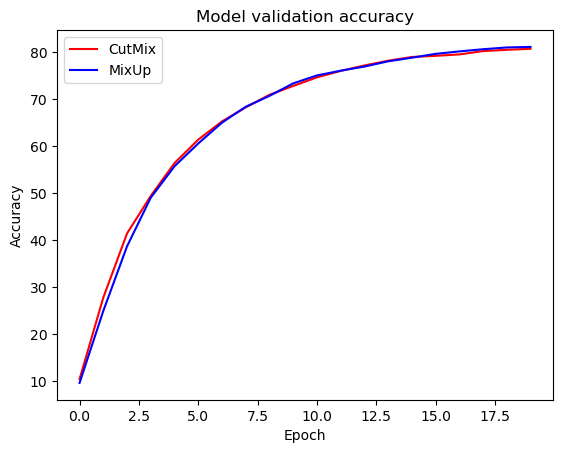

In [71]:
plt.plot(history_resnet50_CM['val_accuracy'], 'r', label='CutMix')
plt.plot(history_resnet50_MU['val_accuracy'], 'b', label='MixUp')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [72]:
# augmentation 미 적용 모델
import torch.nn as nn   # 신경망 모듈
import torchvision.models as models # ResNet-50 모델 불러오기

num_classes = len(ds_info["class_names"])   # 클래스 수
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)   # 사전학습된 ResNet-50 모델
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)   # 출력층 수정

model = nn.Sequential(  # Sequential: 순차적으로 쌓기   
    resnet50, # 사전학습된 ResNet-50 모델
    nn.AdaptiveAvgPool2d((1, 1)),   # 적응형 평균 풀링
    nn.Flatten(),   # 평탄화
    nn.Linear(resnet50.fc.in_features, num_classes),    # 출력층
    nn.Softmax(dim=1)   # 소프트맥스 활성화 함수
)

print("=3")

=3


In [73]:
%%time
import torch.optim as optim # Optimizer

#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

criterion = nn.CrossEntropyLoss()   # 손실함수
optimizer = optim.SGD(resnet50.parameters(), lr=0.001) # Optimizer  

def train(model, train_loader, test_loader, epochs):
    model.to(device)  
    history = {'val_accuracy': []}

    for epoch in range(epochs): 
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)   # 예측된 클래스
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {train_acc:.2f}%")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        history['val_accuracy'].append(val_acc)
        print(f"Validation Accuracy: {val_acc:.2f}%")

    return history

CPU times: user 3.47 ms, sys: 1 ms, total: 4.47 ms
Wall time: 3.69 ms


In [75]:
def normalize_and_resize_img():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 통일
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
    ])

In [76]:
def normalize_and_resize_img(): # 기본 transform 함수
    return transforms.Compose([ # Compose: 여러 transform들을 묶음
        transforms.Resize((224, 224)),  # 크기 통일 
        transforms.ToTensor(),  # Tensor 변환   
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
    ])

transform = normalize_and_resize_img()  # 기본 transform
full_dataset = ImageFolder(root=dataset_dir, transform=transform)   # transform 적용

In [77]:
# 데이터셋 분할
def augment():  # augmentation 함수
    return transforms.Compose([ # Compose: 여러 transform들을 묶음
        transforms.RandomHorizontalFlip(p=0.5), # 50% 확률로 좌우 반전
        transforms.ColorJitter(brightness=0.2)  # 밝기 변화
    ])

print('=3')

=3


In [78]:
# 데이터셋을 가공하는 메인함수
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False):  # with_aug: augmentation 적용 여부
    # 데이터셋에 transform 적용 (augmentation 포함)
    transform = normalize_and_resize_img()  # 기본 transform

    if not is_test and with_aug:    # 테스트셋이 아니고 augmentation 적용 시
        dataset.dataset.transform = transforms.Compose([    # transform들을 묶음
            *augment().transforms,  # augmentation transform들  # 리스트 언패킹 사용    
            *transform.transforms   # 기본 transform들  # 리스트 언패킹 사용
        ])
    else:
        dataset.dataset.transform = transform   # 기본 transform만 적용

    return DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)  # DataLoader 반환


In [79]:
# augmentation 함수 2
import random

def augment2():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전
        transforms.RandomVerticalFlip(p=0.5),    # 상하 반전
        transforms.RandomRotation(degrees=(0, 90, 180, 270)),  # 90도 단위 회전
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 밝기, 대비, 색상 조정
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 랜덤 크롭 후 리사이즈
        transforms.Lambda(lambda img: torch.clamp(img, 0, 1))  # 0~1 값으로 클리핑
    ])


In [80]:
# augmentation 미 적용 모델
import torch.nn as nn   # 신경망 모듈
import torchvision.models as models # ResNet-50 모델 불러오기

num_classes = len(ds_info["class_names"])   # 클래스 수
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)   # 사전학습된 ResNet-50 모델
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)   # 출력층 수정

model = nn.Sequential(  # Sequential: 순차적으로 쌓기   
    resnet50, # 사전학습된 ResNet-50 모델
    nn.AdaptiveAvgPool2d((1, 1)),   # 적응형 평균 풀링
    nn.Flatten(),   # 평탄화
    nn.Linear(resnet50.fc.in_features, num_classes),    # 출력층
    nn.Softmax(dim=1)   # 소프트맥스 활성화 함수
)

In [81]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)  # augmentation 미적용
ds_test = apply_normalize_on_dataset(ds_test, is_test=True) # 테스트셋

In [82]:
%%time
EPOCH = 20
history_resnet50_no_aug = train(resnet50, ds_train_no_aug, ds_test, EPOCH)  # Augmentation 미적용 모델 훈련

Epoch [1/20], Accuracy: 0.74%
Validation Accuracy: 0.77%
Epoch [2/20], Accuracy: 0.71%
Validation Accuracy: 0.69%
Epoch [3/20], Accuracy: 0.80%
Validation Accuracy: 0.73%
Epoch [4/20], Accuracy: 0.77%
Validation Accuracy: 0.65%
Epoch [5/20], Accuracy: 0.69%
Validation Accuracy: 0.79%
Epoch [6/20], Accuracy: 0.62%
Validation Accuracy: 0.71%
Epoch [7/20], Accuracy: 0.68%
Validation Accuracy: 0.72%
Epoch [8/20], Accuracy: 0.73%
Validation Accuracy: 0.61%
Epoch [9/20], Accuracy: 0.64%
Validation Accuracy: 0.71%
Epoch [10/20], Accuracy: 0.67%
Validation Accuracy: 0.73%
Epoch [11/20], Accuracy: 0.63%
Validation Accuracy: 0.71%
Epoch [12/20], Accuracy: 0.71%
Validation Accuracy: 0.68%
Epoch [13/20], Accuracy: 0.65%
Validation Accuracy: 0.76%
Epoch [14/20], Accuracy: 0.71%
Validation Accuracy: 0.71%
Epoch [15/20], Accuracy: 0.71%
Validation Accuracy: 0.79%
Epoch [16/20], Accuracy: 0.63%
Validation Accuracy: 0.75%
Epoch [17/20], Accuracy: 0.75%
Validation Accuracy: 0.69%
Epoch [18/20], Accuracy

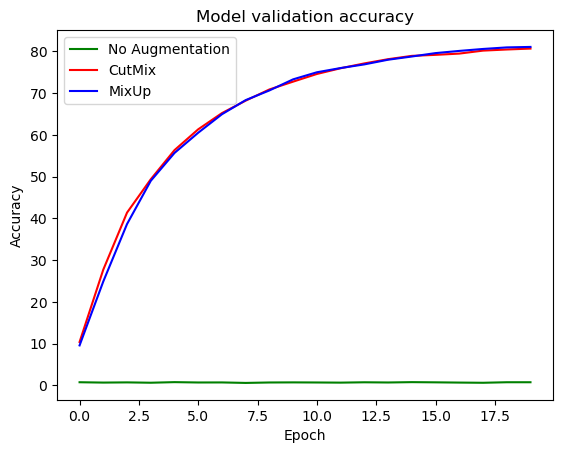

In [88]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'g', label='No Augmentation')
plt.plot(history_resnet50_CM['val_accuracy'], 'r', label='CutMix')
plt.plot(history_resnet50_MU['val_accuracy'], 'b', label='MixUp')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

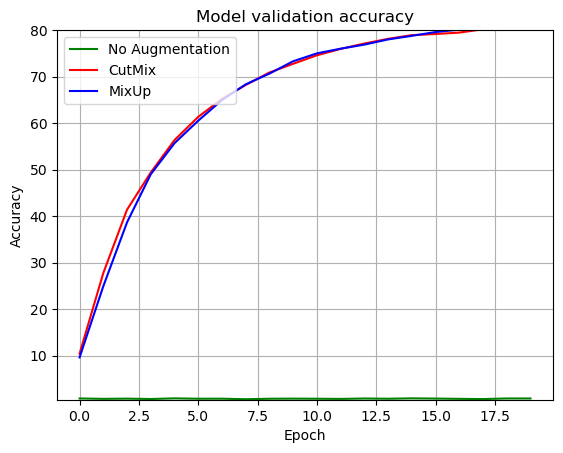

In [91]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'g', label='No Augmentation')
plt.plot(history_resnet50_CM['val_accuracy'], 'r', label='CutMix')
plt.plot(history_resnet50_MU['val_accuracy'], 'b', label='MixUp')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

## 그래프의 스케일이 맞지 않는다.
cutmix는 0-100
No Augmentation은 0~1
스케일을 조정해 보자

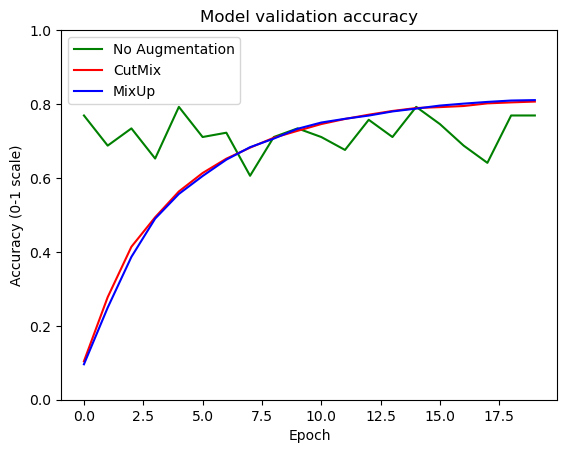

In [95]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'g', label='No Augmentation')
plt.plot([x / 100.0 for x in history_resnet50_CM['val_accuracy']], 'r', label='CutMix')
plt.plot([x / 100.0 for x in history_resnet50_MU['val_accuracy']], 'b', label='MixUp')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy (0-1 scale)')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0, 1)  # y축 범위를 0~1로 설정
plt.show()

아마도 No Aug는 이전에 학습을 테스트를 돌린 상태에서 업데이트를 한것 같다.
망했다.

In [96]:
print("MixUp val_accuracy:", history_resnet50_MU['val_accuracy'])

MixUp val_accuracy: [9.58983919832207, 24.912607783733396, 38.65066418084363, 48.9979025868096, 55.67466790957819, 60.52202283849918, 64.94989512934048, 68.32906082498252, 70.6478676299231, 73.30459100442788, 74.99417385224889, 76.0079235609415, 76.88184572360755, 78.00046609182009, 78.7695175949662, 79.58517828012118, 80.10953157772082, 80.57562339780937, 80.94849685388021, 81.06501980890235]


In [97]:
print("MixUp val_accuracy:", history_resnet50_CM['val_accuracy'])

MixUp val_accuracy: [10.405499883477045, 27.744115590771383, 41.3889536238639, 49.37077604288045, 56.3505010487066, 61.33768352365416, 65.2178979258914, 68.20088557445817, 70.88091353996738, 72.75693311582381, 74.58634350967141, 75.96131437893266, 77.11489163365182, 78.12864134234444, 78.92099743649499, 79.16569564204148, 79.46865532509905, 80.1794453507341, 80.44744814728502, 80.66884176182708]


In [98]:
print("no_aug val_accuracy:", history_resnet50_no_aug['val_accuracy'])

no_aug val_accuracy: [0.7690515031461198, 0.6874854346306223, 0.734094616639478, 0.6525285481239804, 0.7923560941505476, 0.7107900256350501, 0.722442321137264, 0.6059193661151246, 0.7107900256350501, 0.734094616639478, 0.7107900256350501, 0.6758331391284083, 0.7573992076439059, 0.7107900256350501, 0.7923560941505476, 0.7457469121416919, 0.6874854346306223, 0.6408762526217665, 0.7690515031461198, 0.7690515031461198]


## 회고
이번 테스트는 망했다.
코드를 이해해 보기 위해 많은 시간과 노력을 들였지만 결과는 이상했다.
부분만 이해하기 보다 전체의 흐름을 파악해야 했는데 실패했다.
아직 ResNet50 모델 초기화부분을 잘못하고 있는데 좀더 공부해야할 필요성을 느꼈다.
이번 프로젝트를 통해서 다양한 증강 기법을 배웠는데 이전에 테스트 할때는 초기를 제외하고 데이터가 많아서 증강은 필요 없다고 생각 했는데
어떤 부분에서는 도움이 될 것 같다는 생각을 했다.